In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

import tensorflow as tf
from basenji import seqnn, stream

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

2024-05-06 11:35:50.868759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 11:35:50.868862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 11:35:50.872198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 11:35:50.893706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 11:35:52.346338: W tensorflow/comp

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
from akita_utils.dna_utils import dna_1hot

from akita_utils.seq_gens import (
    symmertic_insertion_seqs_gen,
    reference_seqs_gen,
)

from akita_utils.tsv_gen_utils import (
    add_orientation,
    add_background,
    add_diff_flanks_and_const_spacer,
)

In [4]:
# arguments 

genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD,INS-16,INS-64"
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"

In [5]:
# tsv with coordinates of 10 strong sites randomly chosed from the 1st quintile
CTCT_table = "./top10_insSCD.tsv"

In [6]:
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

In [7]:
models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"
print("params_file: ", params_file)
print("model_file: ", model_file)

params_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json
model_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5


## Loading the model

In [8]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

In [9]:
# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

## Generating table with insertion parameters

In [10]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [11]:
# CTCT_table

In [12]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]

In [13]:
seq_coords_df = seq_coords_df.copy()
seq_coords_df["seq_index"] = [i for i in range(len(seq_coords_df))]

In [14]:
flanks = [30]
orient_list = [">"]
# background_indices_list = [i for i in range(10)]
background_indices_list = [0]
flank_spacer_sum=90

In [15]:
rep_unit = seq_coords_df

In [16]:
for i in range(len(flanks)-1):
    seq_coords_df = pd.concat(
                    [seq_coords_df, rep_unit], ignore_index=True
                )

In [17]:
seq_coords_df = seq_coords_df.sort_values(by="seq_index").reset_index(drop=True)

In [18]:
seq_coords_df["flank_bp"] = [30 for i in range(10)]

In [19]:
# adding orientation
seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
seq_coords_df = add_background(
    seq_coords_df, 
    background_indices_list
    )

In [20]:
seq_coords_df["spacer_bp"] = 90 - seq_coords_df["flank_bp"]

In [22]:
# seq_coords_df

## Read sequences and predict maps for backgrounds

In [23]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

# num_insert_backgrounds = seq_coords_df["background_index"].max()
num_insert_backgrounds = 1

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

In [24]:
#################################################################
# predictions for references
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 12s 2s/step


In [26]:
from akita_utils.stats_utils import plot_map
from akita_utils.utils import ut_dense

0


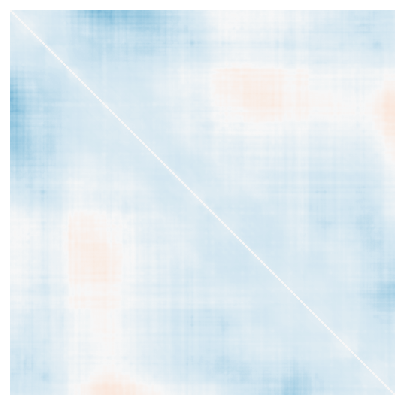

1


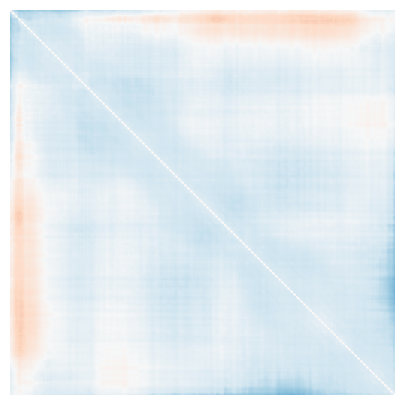

2


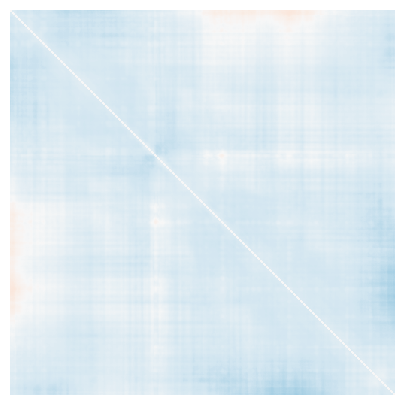

3


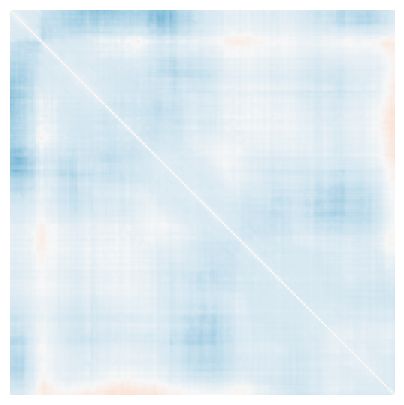

In [27]:
for i in range(4):
    print(i)
    reference_prediction_matrix = backgrounds_predictions[i, :, :]
    ref_maps = ut_dense(reference_prediction_matrix)
    # print("ref")
    # plot_map(ref_maps[:,:,0])
    
    fig = plt.figure(figsize=(5, 5))

    sns.heatmap(
        ref_maps[:,:,0],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    # plt.savefig(f"./example_plots/example_background_{i}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Predict for selected insertions

In [28]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [29]:
num_experiments = len(seq_coords_df)

experiment 0
2/2 [==============================] - 12s 2s/step


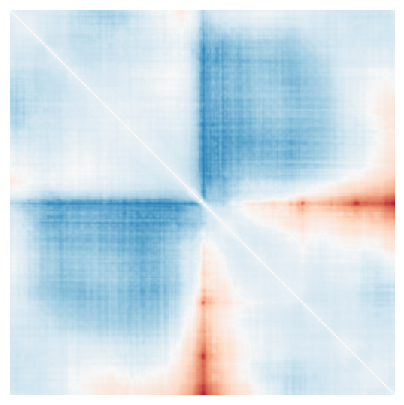

experiment 1


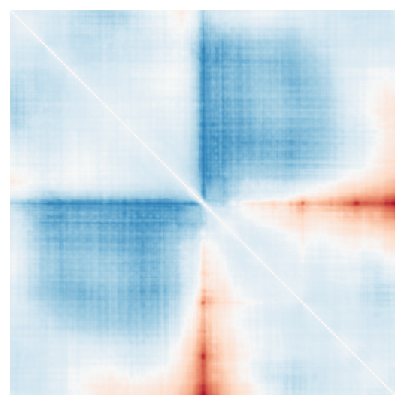

experiment 2


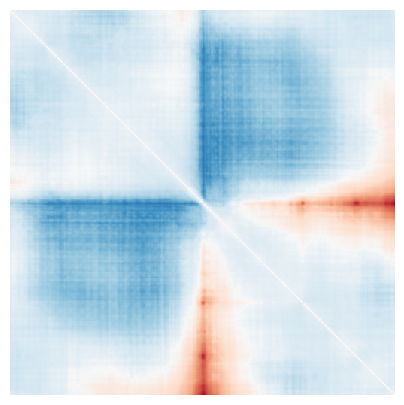

experiment 3


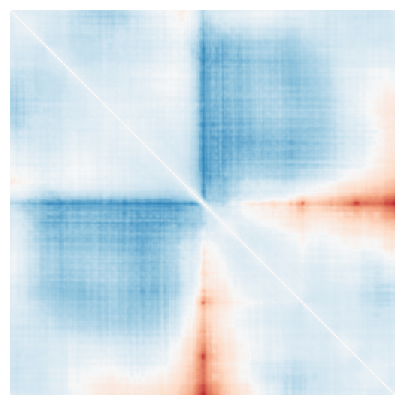

experiment 4


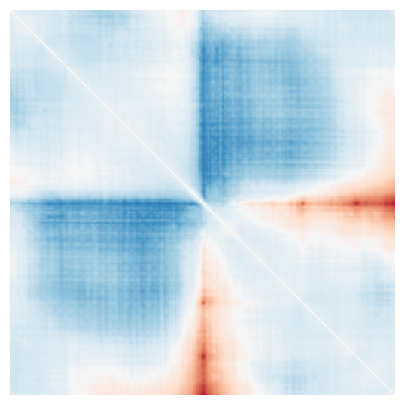

In [30]:
for exp_index in range(5):
    
    print(f"experiment {exp_index}")

    bg_index = seq_coords_df.iloc[exp_index].background_index

    prediction_matrix = preds_stream[exp_index]
    # reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]

    # ref_maps_t0 = ut_dense(reference_prediction_matrix)
    alt_maps_t0 = ut_dense(prediction_matrix)

    # print("ref")
    # plot_map(ref_maps_t0[:,:,0])
    # print("alt")
    # plot_map(alt_maps_t0[:,:,0])
    # print("alt-ref")
    # plot_map(alt_maps_t0[:,:,0] - ref_maps_t0[:,:,0])

    fig = plt.figure(figsize=(5, 5))

    sns.heatmap(
        alt_maps_t0[:,:,0],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    # plt.savefig(f"./example_plots/example_insertion_{exp_index}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [33]:
genome_open.close()